# DS-SF-27 | Codealong 15 | Introduction to Time Series

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from statsmodels.tsa import arima_model
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sb

## Time Series Analysis

## Part A - Data Exploration

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'rossmann.csv'),
    skipinitialspace = True,
    low_memory = False)

In [3]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

In [8]:
df[['Sales']].describe()

,Sales
count,1.017209e+06
mean,5.773819e+03
std,3.849926e+03
min,0.000000e+00
25%,3.727000e+03
50%,5.744000e+03
75%,7.856000e+03
max,4.155100e+04


In [13]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [9]:
df.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [14]:
df.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, dtype: object

In [15]:
df.Date = pd.to_datetime(df.Date)

In [16]:
df.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, dtype: datetime64[ns]

In [17]:
df.set_index('Date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month

df.Sales = df.Sales.astype(float)

Let's focus on the first store.

In [18]:
df = df[df.Store == 1]

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

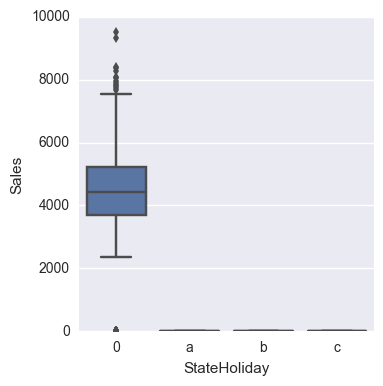

In [19]:
sb.factorplot(x = 'StateHoliday',
              y = 'Sales',
              data = df,
              kind = 'box')

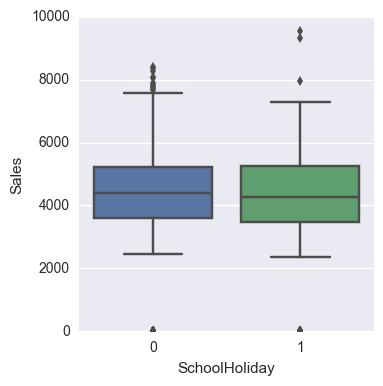

In [20]:
sb.factorplot(x = 'SchoolHoliday',
              y = 'Sales',
              data = df,
              kind = 'box')

> Check: See if there is a difference affecting sales on promotion days.

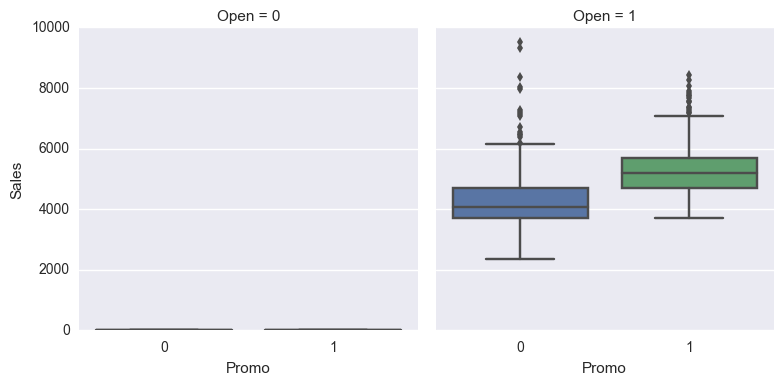

In [21]:
sb.factorplot(col = 'Open',
              x = 'Promo',
              y = 'Sales',
              data = df,
              kind = 'box')

## Part B - Seasonality, Trends, and Cycles

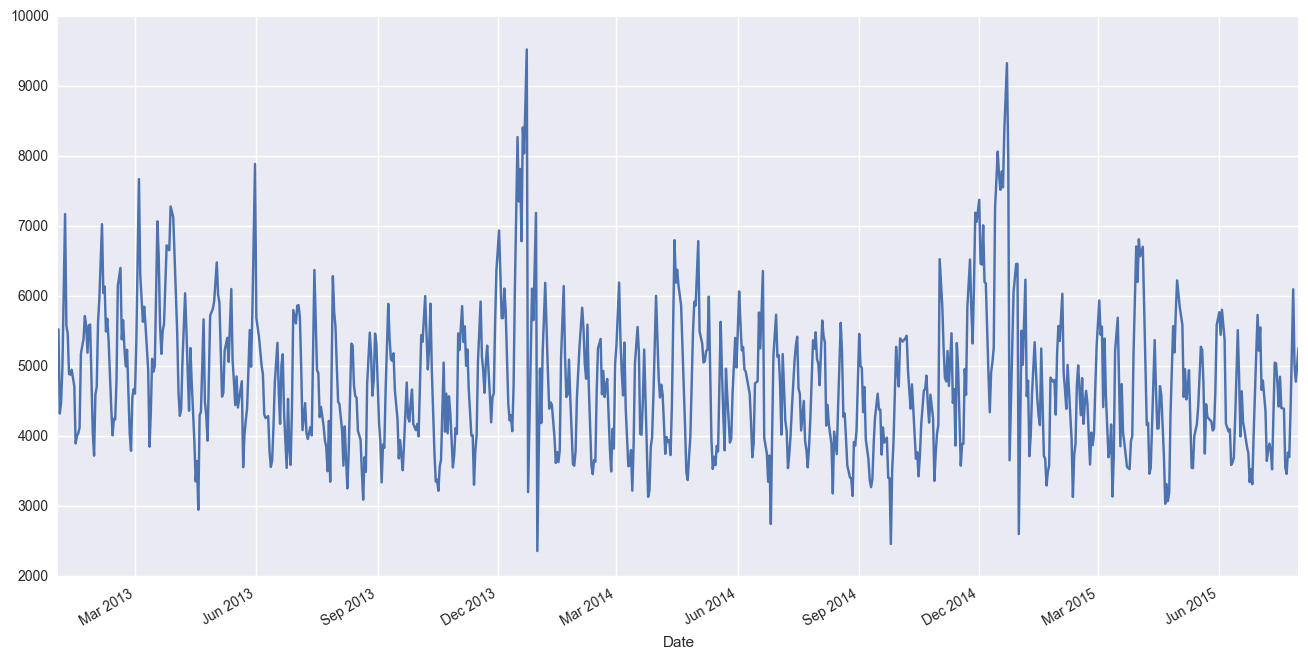

In [26]:
df[df.Open == 1].Sales.plot(figsize=(16,8))

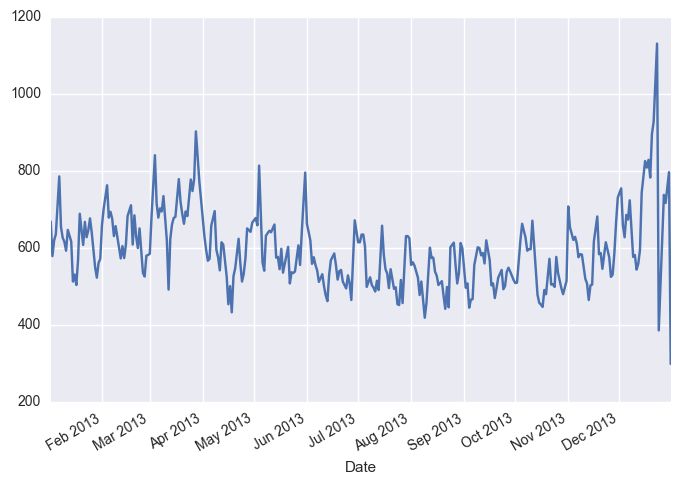

In [27]:
df[(df.Open == 1) & (df.Year == 2013)].Customers.plot()

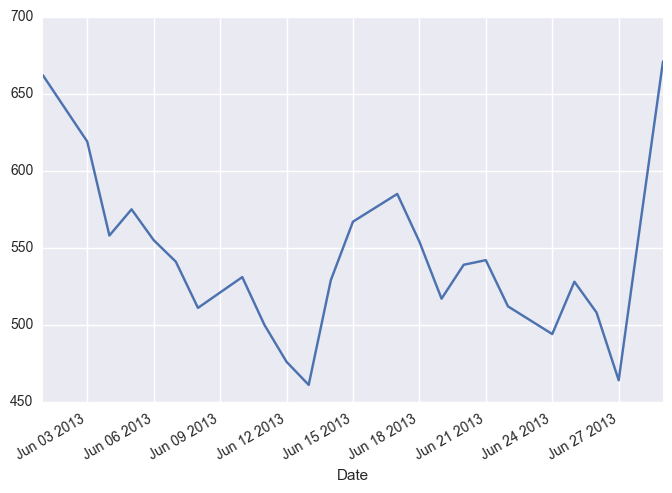

In [28]:
df[(df.Open == 1) & (df.Year == 2013) & (df.Month == 6)].Customers.plot()

## Part C - Rolling Averages; `pandas` Window and Expending Functions

In `pandas`, we can compute rolling averages using the `Series.rolling` function.

### Rolling averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In `pandas`, this is performed using the `resample` command, which is very similar to the `groupby` command.  It allows us to group over different time intervals.

We can use `Series.resample` and provide as arguments:
- The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
- What aggregation to perform: '.mean()', '.median()', 'sum.()', etc.

In [29]:
df.Sales.resample(rule = 'M').mean()

Date
2013-01-31    4142.935484
2013-02-28    4473.964286
2013-03-31    4682.870968
2013-04-30    3933.633333
2013-05-31    3813.709677
                 ...     
2015-03-31    3836.032258
2015-04-30    3688.500000
2015-05-31    3394.193548
2015-06-30    3667.033333
2015-07-31    3911.806452
Freq: M, Name: Sales, dtype: float64

In [30]:
df.Sales.resample(rule = 'M').median()

Date
2013-01-31    4717.0
2013-02-28    5118.5
2013-03-31    5506.0
2013-04-30    4378.0
2013-05-31    4624.0
               ...  
2015-03-31    4005.0
2015-04-30    4139.5
2015-05-31    4211.0
2015-06-30    4045.0
2015-07-31    4395.0
Freq: M, Name: Sales, dtype: float64

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window.  To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it.  We can do this using rolling averages.

In `pandas`, we can compute rolling averages using the `Series.rolling` function.

In [31]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 3, center = True).mean()

Date
2013-01-01            NaN
2013-01-02    3285.666667
2013-01-03    4781.000000
2013-01-04    4603.333333
2013-01-05    3161.000000
                 ...     
2015-07-27    3704.333333
2015-07-28    5298.333333
2015-07-29    4937.666667
2015-07-30    5021.666667
2015-07-31            NaN
Freq: D, Name: Sales, dtype: float64

`rolling` takes these important parameters:
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

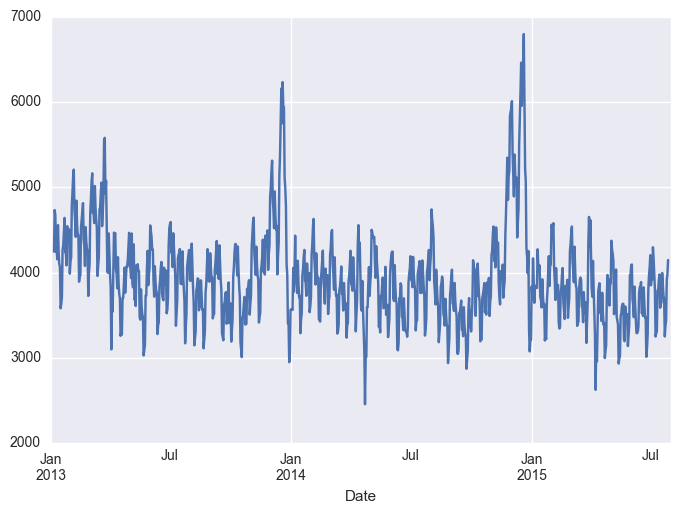

In [32]:
df.Sales.resample(rule = 'D').mean().\
    rolling(window = 10, center = True).mean().\
    plot()

### `pandas` window functions

`pandas`' `rolling` is only one examples of `pandas`' window function capabilities.  Window functions are operate on a set of N consecutive rows (a window) and produce an output.

Another common one is `diff`, which takes the difference over time.  `Series.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.

In [33]:
df.Sales.diff(periods = 1)

Date
2015-07-31       NaN
2015-07-30    -243.0
2015-07-29    -238.0
2015-07-28     229.0
2015-07-27    1091.0
               ...  
2013-01-05    4997.0
2013-01-04    -511.0
2013-01-03    -159.0
2013-01-02    1203.0
2013-01-01   -5530.0
Name: Sales, dtype: float64

### `pandas` expanding functions

In addition to the `rolling` function, `pandas` also provides a similar `expanding` function, which, instead of using a window of N values, use all values up until that time.

In [ ]:
# computes the average sales, from the first date _until_ the date specified.

df.Sales.resample(rule = 'd').mean().\
    expanding().mean()

## Part D - Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column.  In `pandas`, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation.  If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it.  Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [34]:
df.Sales.autocorr(lag = 1)

-0.12732514339140219

In [35]:
df.Sales.autocorr(lag = 7)

0.63071924328402895

We can plot many autocorrelations at once.

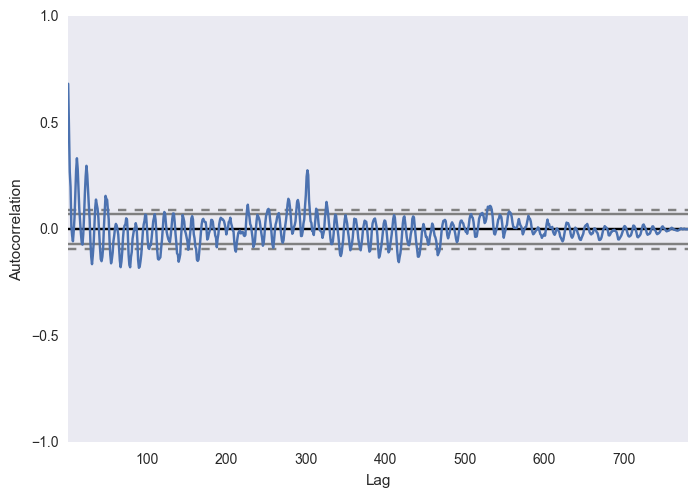

In [36]:
pd.tools.plotting.autocorrelation_plot(df[df.Open == 1].Sales)

This shows a typical pattern of an autocorrelation plot, that it should decrease to 0 as lag increases.  However, it's hard to observe exactly what the values are.

## Part E - Time Series Modeling

Above, we computed autocorrelation for the data at varying lag periods.  This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day, week, or month.

### Activity | Using the autocorrelation plot, will we be able to use a predictive model, particularly an autoregressive one?

Answer: TODO

### `statsmodels` and autocorrelation plots

`statsmodels` has a better autocorrelation plot that allows us to look at fixed number of lag values.

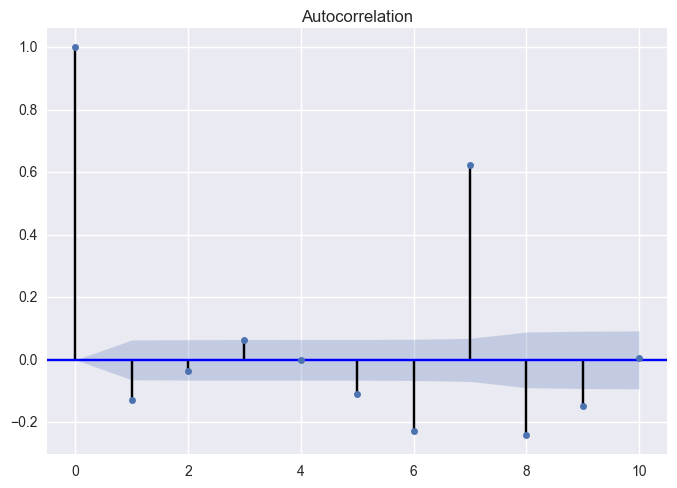

In [37]:
plot_acf(df.Sales, lags = 10)

pass

Here we observe autocorrelation at 10 lag values.  1 and 2 are what we saw before.  This implies a small but limited impact based on the last few values.  An autoregressive model might be useful.  We also see a larger spike at 7 (the seventh day in the week).

If we observed a handful of random distributed spikes, a moving average model would be useful.

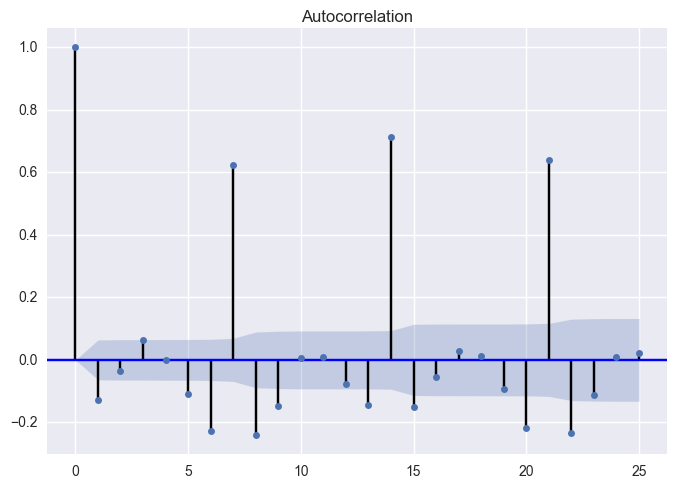

In [38]:
plot_acf(df.Sales, lags = 25)

pass

Expanding the window to 25 days, we can see that the random spikes occur regularly at 7 days.  What does this mean?

### `statsmodels` and `AR`, `MA`, `ARMA`, and `ARIMA` models

In this class, we will use `statsmodels` to code `AR`, `MA`, `ARMA`, and `ARIMA` models.

To explore `AR`, `MA`, `ARMA`, and `ARIMA` models, we will use `sm.tsa.arima_model.ARIMA`.

In [39]:
model = arima_model.ARIMA(df[df.Open == 1].Sales, (1, 0, 0)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Thu, 27 Oct 2016   AIC                          12540.651
Time:                        20:43:58   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

By passing `(1, 0, 0)` in the second argument, we are fitting an `ARMA` model with `p = 1`, `d = 0`, and `q = 0`.  This is the same as an `AR(1)` model.

In this `AR(1)` model, we learn an intercept (or base sales) value.

Additionally, we learn a coefficient that tells us how to include the latest sales value.

In this case, we add an intercept of ~4800 to .68 times the previous month's sales.  Note that the coefficient is not equal to the lag 1 autocorrelation.  This implies the data is __not__ stationary.

We can learn an `AR(2)` model, which regresses each sales value on the last two.

In [ ]:
model = arima_model.ARIMA(df.Sales, (2, 0, 0)).fit()

model.summary()

In this case, we learn two coefficients, which tell us the effect of the last two sales values on the current sales.  While this model may perform better, it may be more difficult to interpret.

## Residuals

To start to diagnose the model, we want to look at residuals.

1. What are residuals?
1. In linear regression, what did we expect of residuals?

- Residuals are the errors of the model or how off our predictions are
- Ideally, we want randomly distributed errors that are small
- If the errors are large, our model does not perform well
- If the errors have a pattern, particularly over time, we may have overlooked something in the model or have periods of time that are different than the rest of the dataset

We can use `statsmodels` to plot the residuals.

In [ ]:
model.resid.plot()

Our model considers a short period of time, so it does not take into account the longer seasonal pattern.  We can also plot the autocorrelations of the residuals.  In an ideal world, these would all be near 0 and appear random.

In [ ]:
plot_acf(model.resid, lags = 50)

pass

This plot shows a problem: the errors are increasing and decreasing every week in a clear pattern.  We may need to expand our model.  To expand this `AR` model to an `ARMA` model, we can include the moving average component as well.

In [ ]:
model = arima_model.ARIMA(df.Sales, (1, 0, 1)).fit()

model.summary()

Now we learn two coefficients, one for the `AR(1)` component and one for the `MA(1)` component.

### Activity

1. Take a moment to look at the coefficients of our new model
1. Offer an interpretation of this model

Answer: TODO

Let's fit a true `ARIMA` model to predict the difference of the series.

In [ ]:
model = arima_model.ARIMA(df[df.Open == 1].Sales, (1, 1, 1)).fit()

model.summary()

We can remove the `MA` component since it does not appear to be useful.

In [ ]:
model = arima_model.ARIMA(df[df.Open == 1].Sales, (1, 1, 0)).fit()

model.summary()

We now have an `AR(1)` model on the differenced series with a coefficient of -.18.

### Activity

1. Does this model match the lag 1 autocorrelation of the differenced series?
1. Is the data stationary?

In [ ]:
# TODO

With our models, we can also plot our predictions against the true series using the plot_predict function: We can compare the last 50 days of true values against our predictions.

In [ ]:
model.plot_predict(1, 50)

pass

The function takes two arguments, the start and end index of the dataframe to plot.  Here, we are plotting the last 50 values.  To plot earlier values with our predictions continuing where the true values stop, we can do the following.

In [ ]:
_, ax = plt.subplots()
ax = df['2014'][df.Open == 1].Sales.plot(ax = ax)

model.plot_predict(1, 200, ax = ax, plot_insample = False)

pass

This plots true values in 2014 and our predictions 200 days out from 2014.

### Activity

We can revisit our diagnostics to check that our models are working well.

1. Plot the residuals and autocorrelation of the residuals.
1. Are there patterns or outliers?

Answer: TODO

We can adjust the `AR` component of the model to adjust for a piece of this.  Let's increase the lag to 7.

In [ ]:
model = arima_model.ARIMA(df[df.Open == 1].Sales, (7, 1, 2)).fit()

model.summary()

In [ ]:
plot_acf(model.resid, lags = 50)

pass

This removes some of the autocorrelation in the residuals but large discrepancies still exist.

However, they exist where we are breaking our model assumptions.

### Activity

1. Alter the time period of predictions and the `p`, `d`, and `q` parameters
1. Do any of these improve diagnostics?
1. What does changing `p` and `q` imply based upon the autocorrelation plot?
1. How about changing `d`?

Answer: TODO

There are variants of `ARIMA` that will better handle the seasonal aspect of our data.  This is referred to as Seasonal `ARIMA` or `SARIMA`.

These models fit two `ARIMA` models, one on the current frequency (daily in our example) and another on the seasonal frequency (maybe monthly or yearly patterns).

Additionally, issues with seasonality could be handled by preprocessing tricks such as detrending.